# Predicting Insurance Costs Using Linear Regression


## Intoduction
For this guided project I will be working with the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

Start by importing the required libraries.

In [1]:
# import the libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

Read the file and inspect the first five rows.

In [2]:
# read the file
insurance = pd.read_csv('/Users/sumersener/Downloads/Datasets/insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploring the Dataset
In this section I will perform Exploratory Data Analysis by plotting various graphs and analysing and tackling the missing values in the dataset.

Start the EDA by checking for missing values.

In [3]:
# check for missing values
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset has no missing values as seen above. 
<br>

### Plotting the Boxplots
Next, I will plot boxplots of the `charges` column stratified by each of the other columns.

Start by extracting the list of all predictor variables.

In [4]:
# extract feature col names
plt.figure(figsize=(12,8))
feature_cols = list(insurance.columns)
feature_cols.remove('charges')
print(feature_cols)

['age', 'sex', 'bmi', 'children', 'smoker', 'region']


<Figure size 1200x800 with 0 Axes>

Plot the boxplots.

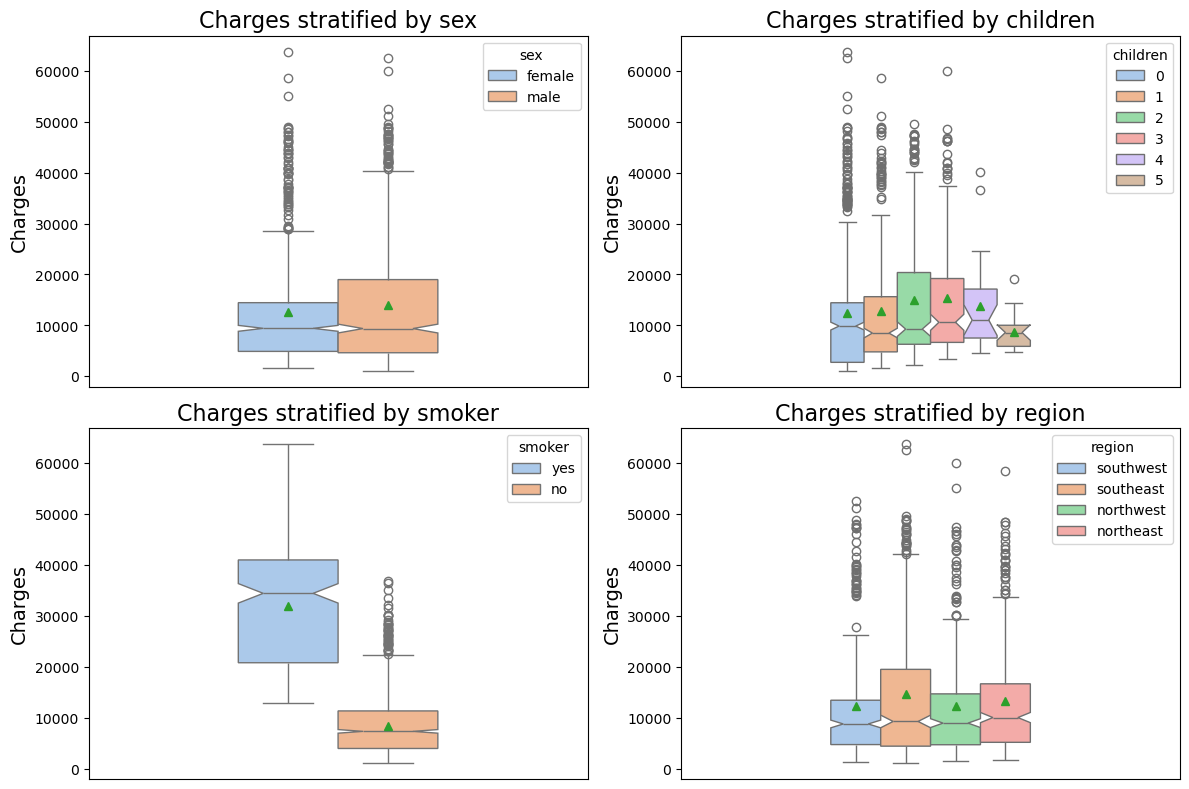

In [5]:
# plot the boxplots
plt.figure(figsize=(12,8))

for idx, col in enumerate(['sex','children','smoker','region']):
    ax = plt.subplot(2,2, idx+1)
    sns.boxplot(data = insurance,
                y = 'charges',
                hue = col,
                palette = 'pastel',
                notch = True,
                width=0.4,
                showmeans = True)
    
    
    ax.set_title('Charges stratified by {}'.format(col), fontsize = 16)
    ax.set_ylabel('Charges', fontsize = 14)
    ax.set_xticks([])
    
plt.tight_layout()

The most striking boxplot is the one corresponding to the `smoker` column. There is a massive difference between the median and interquartile range of the boxplots corresponding to the smokers and non-smokers. Thus, we expect the `smoker` column to be highly correlated to the `charges` column and we will include it when training our model.

### Visualising `age` and `bmi` Columns

Use kernel density plots to visualise the distribution of the `age` column. Becuause the `age` column is continuous we have to find a way of categorizing the data. I will use three bins when plotting a kde plot.

<Figure size 1200x1200 with 0 Axes>

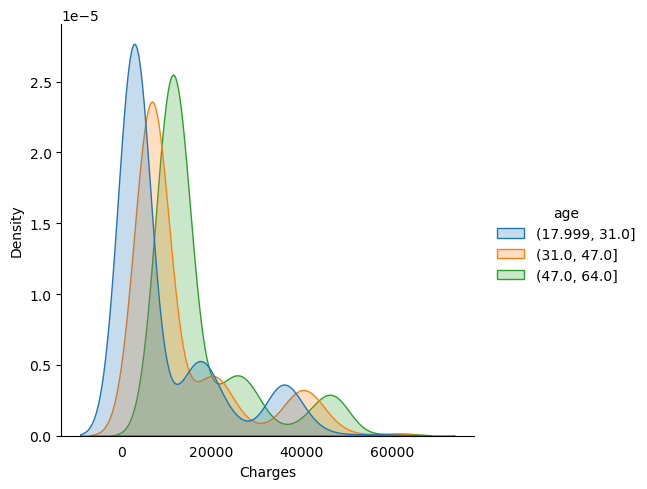

In [6]:
# kde plot of the age column
plt.figure(figsize=(12,12))
ax = sns.displot(insurance, 
                 x="charges", 
                 hue=pd.qcut(insurance['age'], 3), 
                 kind="kde", 
                 fill=True)

ax.tick_params(bottom = False )
ax.set_xlabels('Charges')



As seen in the kde plot above, as the age gets goes up, so does the mode of the charges. Hence we would judge that there is a positive correlation between the `charges` column and the `age` column.

Similar to the kde plot of the `age` column, plot a kde plot of the `bmi` column.

<Figure size 1200x1200 with 0 Axes>

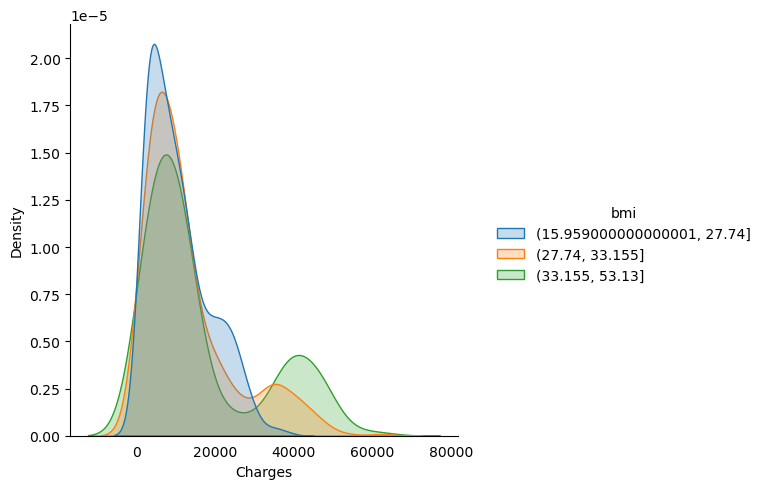

In [7]:
# kde plot of the bmi column
plt.figure(figsize=(12,12))
ax = sns.displot(insurance, 
                 x="charges", 
                 hue=pd.qcut(insurance['bmi'], 3), 
                 kind="kde", 
                 fill=True)

ax.tick_params(bottom = False )
ax.set_xlabels('Charges')


Judging by the kde plot above, similar to the `age` column, as teh bmi grows higher, we expect the charges to grow as well. 

Plot a kde plot of the `smoker` column.

<Figure size 1200x1200 with 0 Axes>

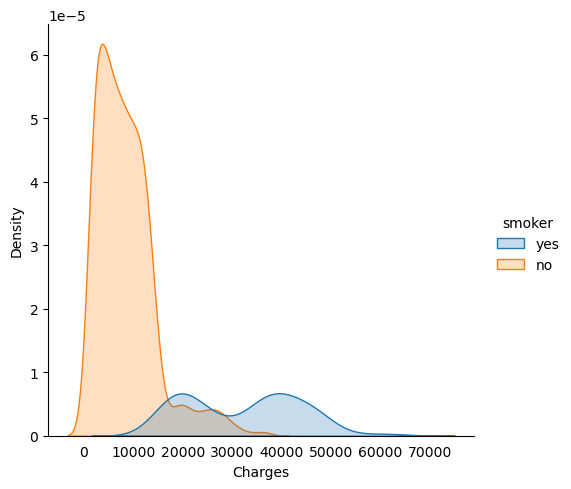

In [8]:
# kde plot of the smoker column
plt.figure(figsize=(12,12))
ax = sns.displot(insurance, 
                 x="charges", 
                 hue=insurance['smoker'], 
                 kind="kde", 
                 fill=True)

ax.tick_params(bottom = False )
ax.set_xlabels('Charges')


I plotted the kde plot of the `smoker` column to have something to compare the other two columns against. We can see that the `bmi` column doesn't have a strong correlation to the charges column nor does the `age` column. However, it is visible from the kde plots that for higher `bmi` and `age` the `charges` tend to be higher as well. This is in line with what we would expect because we would expect old people and unhealthy people to have more health problems than the rest of the population.

### Heatmap of the Columns
Plot a heatmap of the columns to see what we've discovered above is in line with what the heatmap suggests. 

Start by creating dummy variables because we can't feed categorical columns into the heatmap. 

In [9]:
# convert categorical variables to dummy variables 
insurance_modif = pd.get_dummies(data= insurance,
                                columns=['sex', 'smoker','region'],
                                drop_first=True)

Inspect the first five rows of the modified dataset.

In [10]:
# inspect the first five rows
insurance_modif.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


Compute the correlation matrix to be able to plot a heatmap of the columns using the correlation matrix. 

In [11]:
# inspect the correlation matrix
insurance_modif.corr()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109272,0.042469,0.299008,-0.020856,-0.025019,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.198341,0.046371,0.003750,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.067998,0.017163,0.007673,0.024806,-0.023066,0.021914
charges,0.299008,0.198341,0.067998,1.000000,0.057292,0.787251,-0.039905,0.073982,-0.043210
sex_male,-0.020856,0.046371,0.017163,0.057292,1.000000,0.076185,-0.011156,0.017117,-0.004184
smoker_yes,-0.025019,0.003750,0.007673,0.787251,0.076185,1.000000,-0.036945,0.068498,-0.036945
region_northwest,-0.000407,-0.135996,0.024806,-0.039905,-0.011156,-0.036945,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.270025,-0.023066,0.073982,0.017117,0.068498,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.006205,0.021914,-0.043210,-0.004184,-0.036945,-0.320829,-0.346265,1.000000


Plot the heatmap of the columns. Only include the squares that have a correlation of higher than or equal to magnitude of 0.1.

<Axes: >

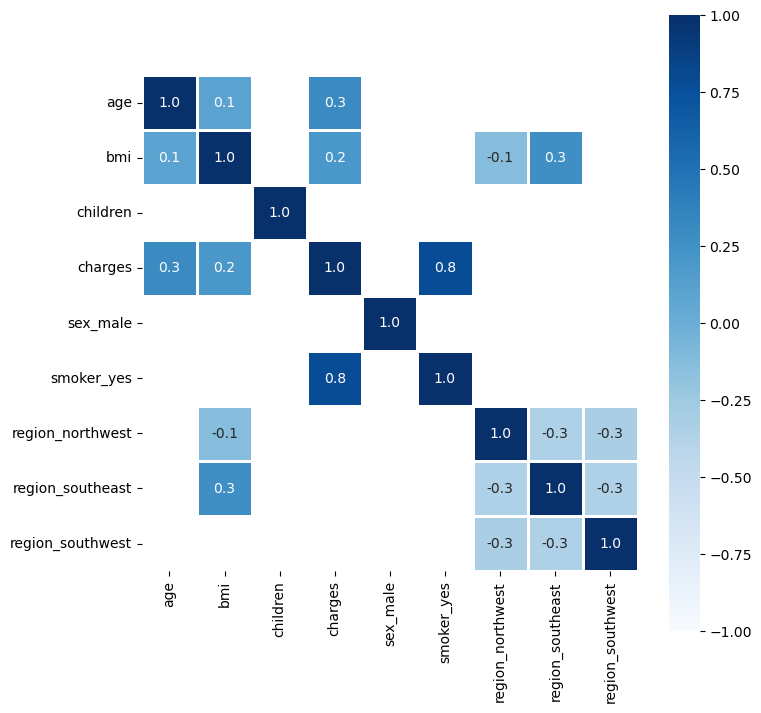

In [12]:
# plot a heatmap of the correlation matrix
plt.figure(figsize = (8,8))
sns.heatmap(insurance_modif.corr()[insurance_modif.corr().abs() >0.1], 
            cmap = 'Blues', 
            center = 0, 
            robust = True,
            vmin = -1, 
            vmax = 1, 
            annot = True, 
            fmt = '0.1f', 
            linewidth = 1, 
            square =True)

As commented before, there is a very strong positive correlation between `smoker_yes` columna and `charges` column. this is followed by the `bmi` and `age` columns which have weak positive correlation with the `smoker` column. Moving on, I will train my model using these three columns.

## Dividing The Data
To be able to train our model, we need to divide the data into training and test sets. 

Start by creating variables for the target column and the predictor columns.

In [13]:
# isolate the feature columns and the target column
X = insurance_modif[['smoker_yes', 'bmi','age']]
y = insurance_modif['charges']

Use the `StandardScaler` to scale the training and test datasets.

In [14]:
# instantiate the StandardScaler object and scale the training and test sets 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=0)

## Build The Model
Create and instance of the `LinearRegression` model. Fit this model to the training data and pring out the coefficients of our linear regression fit.

In [17]:
# instantiate the LinearRegression class
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
lm.coef_

The coefficient associated with a predictor should be interpreted as the change in the average outcome for a unit change in the predictor. For categorical variables, a unit change signifies a change in the category for a categorical variable. 
<br> Hence, the coefficient of the `smoker_yes` column is high as expected because there is a big difference between the `charges` for a non-smoking person and smoking person, as explored using boxplots above.<br>
Moreover, the fact that the `bmi` column has a higher coefficient than the `age` column is in parallel with the fact that `age` column has a higer correlation with the `charges` column. Thereofore, we would expect a unit increase in the `age` predictor to have a greater effect than a unit increase in the `bmi` predictor.


### Metrics of the Model
Use different metrics to analyse how well our model is predicting.

Start by computing the coefficient of determination.

In [20]:
# examine the coefficient of determination of the model
train_r2 = r2_score(y_train, lm.predict(X_train_scaled))
train_r2

0.7342532129942392

Next, compute the mean squared error.

In [21]:
# Calculate the mean squared error (MSE) based on just the training set
mse_train_pred = mean_squared_error(y_train, lm.predict(X_train_scaled))
mse_train_pred

38099093.83791883

Having coefficient of determination above 0.70 is a good indication. Meaning that more than 70% of the varation in the target column is being caused by the features we're examining. 
<br> On the flipside, the MSE is quite high and we should do some work to recuce the MSE.

## Residual Diagnostics
Sor far we have trained and fitted our model. However, before we continue further we should examine how well our linear model is complying with the assumptions.

To start wiht, compute the residuals, meaning the difference between the `y_train` values and the predicted values using `X_train_scaled`.

In [28]:
# compute the residuals
fitted_values  = lm.predict(X_train_scaled)
residuals = y_train - fitted_values

Count how many of the residuals are negative.

In [29]:
# how many of the residuals are negative
np.sum((residuals < 0).values.ravel())

667

Count the number of rows in the the training dataset.

In [30]:
# total number of values in the residuals
residuals.shape[0]

1070

Compute what percentage of the residuals are negative.

In [31]:
# percentage of negative residuals
667/1070

0.6233644859813084

As can be seen above, majority of the residuals are negative. In fact, more than 60% of the residuals are negative. This suggests that the model has a tendency to underestimate the charges.

### Plotting Residuals against the Fitted Values
Plot the residuals against `fitted_values`. 

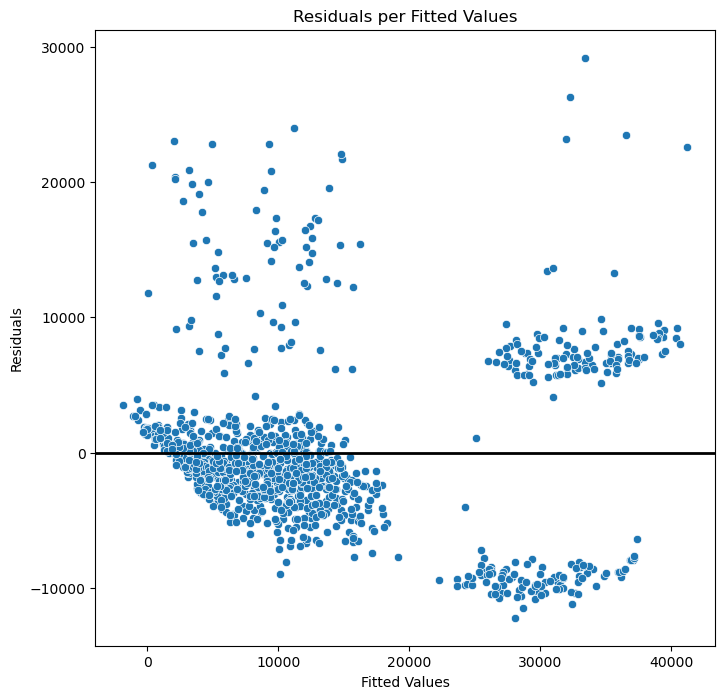

In [32]:
# plot the residuals against fitted values
fig, ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x = fitted_values,
               y = residuals)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals per Fitted Values')
plt.axhline( y = 0, 
           color = 'black',
           linewidth = 2)

Looking at the above graph, the residuals certainly don't seem to be centred around 0 over the range of the fitted values. <br>
Moreover, they don't have a fixed variation around the `y=0` line. We can see that the points above the horizontal line are further away from the line that the points below the line.<br>
Hence, we can conclude that the residuals don't seem to agree with the linear model assumptions.

## Interpreting The Model

### The Intercept
The intercept gives the value when all of the predictors take value 0. In our model this doesn't make sense becasue it would mean that we are dealing with a person who has 0 `bmi` and 0 years of `age`.

In [41]:
# get the intercept of the model
lm.intercept_

13212.651357276503

### Regression Coefficients


In [43]:
# get the regression coeffs of the model
lm.coef_

array([9533.80159416, 1961.90677633, 3610.06136538])

Notice that the `smoker_yes` column has the highest regression coefficient of all. The regression coefficient of this predictor is 9500 to the nearest hundred. Because this column only takes values `0` or `1`, this means that the expected charge increase between a non-smoker and smoker is roughly 9500 dollars. Therefore, if our insurance company is insuring a smoker, we would be looking to charge them 9500 more than someone who has the exact same characteristics for other columns but doesn't smoke.

Moreover, we can see that a unit increase in the `bmi` column is associate with an increase of almost 2000 dollars in the insurance charges.

A unit increase in the `age` column is associated with an increase of roughtly 3500 dollars in the charges.

## Final Model Evaluation

### Test Data Predictions
Now it's time to test our model on unseen data. Use the test dataset created before for this purpose.

Compute the predicted values for the test dataset and compute the mean squared error between these values and the actual values of the target variable in the test dataset.

In [34]:
# predict the fitted values for the X_test dataset
test_pred = lm.predict(X_test_scaled)
mse_test_pred = mean_squared_error(y_test, test_pred)
mse_test_pred

Examine if the mean squared error is higher in the training set than the test set.

In [36]:
# compare the mse values for the test and train data
print(mse_train_pred>mse_test_pred)

True


The MSE value for the test data is better than the MSE value for the training data. This is a good indication meaning that our model is not overfitting and it predicts unseen data well. It would be good to check the coefficient of determination as well.

### Coefficient of Determination
I will compute the coefficient of determination for the test data and compare it with that of the train data. I will use cross validation to compute the coefficient of determination of my model more accurately.

Start by computing the coefficient of determination for the test dataset.

In [37]:
# compute r2 score for the test data
test_r2 = r2_score(y_test, test_pred)
test_r2

0.7945500805653078

Compare the coefficients of determination obtained from the test set and the training set.

In [38]:
# comparet r2 values for the train and test datasets
print(train_r2>test_r2)

False


Next, use cross validation to obtain a more accurate coefficient of determiation for the whole dataset.

In [39]:
# use cross validation for a better r2_score
fold_r2s = cross_val_score(lm, X_scaled, y, cv = 10, scoring = "r2")
np.mean(fold_r2s)

0.7432289194657906

We see that the coefficient of determination is higher for the test data than for the train data. This shows once more that our model is doing a good job of predicting unseen data. Moreover, the coefficient of determination for the test data is almost 0.8, meaning that 80% of the variation in the test data can be attributed to the 3 predictors we have used in our model. <br>
As a result of cross validation the coefficient of determination of the model was calculated to be 74%. This is means that 74% of the variation in the target column can be attributed to the 3 predictors we have determined before.

## Drawing Conclusions

The linear regression model we have trained achieved a coefficient of determiation of 79% on the test set. We used the three columns `smoker_yes`, `bmi`, and `age` as predictor variables. The coefficient of determination suggests that these three columns explain 79% of the variance in the target column. This score could be improved further via feature enginering to create better predictors using the variables we already have.

We have found that our model underestimates the charges in more than 60% of the cases. This is not a good indication because this would mean that the hospital could have difficulties budgeting if they are systematically lead to believe that they wil require less than than actually will. 

The model could be improved further by using `GridSearchCV` for hyperparameter tuning.